# Suppression d'obstacles dans une série d'images

In [1]:
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import math
from IPython.display import HTML
import time
import pickle

In [3]:
%load_ext line_profiler

In [4]:
from skimage.io import imread

boulangerie, leopard, danse = [],[],[]

for i in range(5):
    name_im = "boulangerie" + str(i+1)
    filename = 'boulangerie/{}.png'.format(name_im)
    boulangerie.append(imread(filename))
    name_im = "leopard" + str(i+1)
    filename = 'leopard/{}.png'.format(name_im)
    leopard.append(imread(filename))
    name_im = "danse" + str(i+1)
    filename = 'danse/{}.png'.format(name_im)
    danse.append(imread(filename))

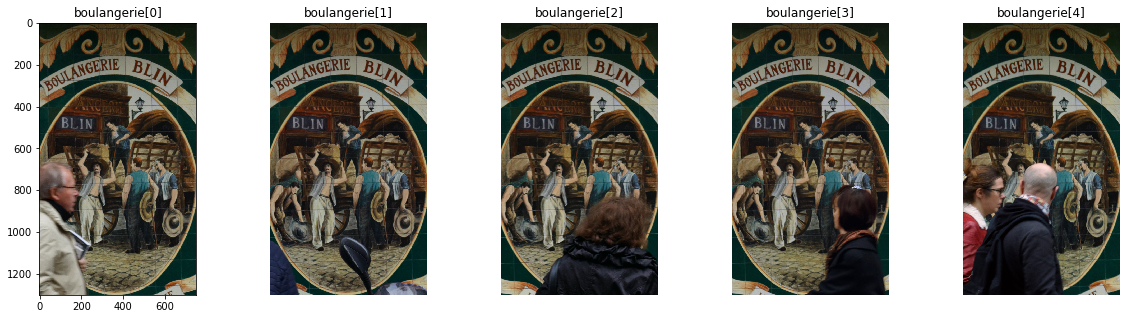

In [5]:
plt.figure(figsize=(20,5))
plt.subplot(151)
plt.title("boulangerie[0]")
plt.imshow(boulangerie[0])
#plt.axis('off')
plt.subplot(152)
plt.title("boulangerie[1]")
plt.imshow(boulangerie[1])
plt.axis('off')
plt.subplot(153)
plt.title("boulangerie[2]")
plt.imshow(boulangerie[2])
plt.axis('off')
plt.subplot(154)
plt.title("boulangerie[3]")
plt.imshow(boulangerie[3])
plt.axis('off')
plt.subplot(155)
plt.title("boulangerie[4]")
plt.imshow(boulangerie[4])
plt.axis('off')

plt.show()

# Méthode par la médiane

In [6]:
def median_3d(ims):
    dists = []
    for im in ims:
        dists.append(0)
        for im2 in ims:
            dists[-1] += np.linalg.norm(im2-im)**2
    indexes = np.argsort(dists)
    return indexes[0], (dists[indexes[0]]==dists[indexes[1]])        

In [35]:
##### Test avec la méthode de la médiane #####

n = len(boulangerie)
size = boulangerie[0].shape

boulangerie_med = np.zeros(size)
unicity_map = np.zeros(size)

for i in range(size[0]):
    for j in range(size[1]):
        ims = [boulangerie[k][i,j] for k in range(n)]
        med, uni = median_3d(ims)
        boulangerie_med[i,j] = boulangerie[med][i,j]
        unicity_map[i,j] = [255*uni]*3

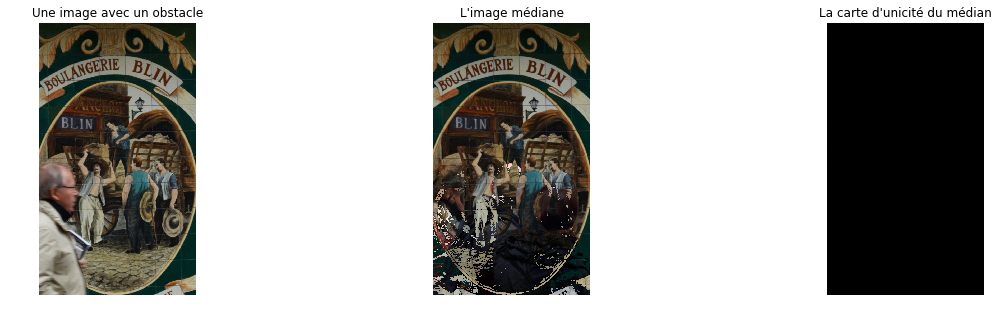

In [48]:
plt.figure(figsize=(20,5))
plt.subplot(131)
plt.title("Une image avec un obstacle")
plt.imshow(boulangerie[0])
plt.axis('off')
plt.subplot(132)
plt.title("L'image médiane")
plt.imshow(boulangerie_med.astype(np.uint8))
plt.axis('off')
plt.subplot(133)
plt.title("La carte d'unicité du médian")
plt.imshow(unicity_map)
plt.axis('off')

plt.show()

# Méthodes par les cliques

### Algorithme 1 : Détermination des cliques denses

In [30]:
def NN_matrix(phi):
    n=len(phi)
    mat=np.zeros((n,n))
    for i in range(n):
        dists = []
        for im2 in phi:
            diff = im2.astype(int) - phi[i]
            dists.append(np.linalg.norm(diff)**2)
        mat[i] = np.argsort(dists)
    return mat

In [78]:
def dense_cliques(phi, m, mat, thresh):
    S = []
    n = len(phi)
    
    matrix = mat[:,:m]
    for i in range(n):
        matrix[i] = np.sort(matrix[i])
    
    yetToSee = range(n)
    for i in yetToSee:
        clique = []
        for j in yetToSee:
            if (np.all(matrix[i]-matrix[j] == 0)):
                clique.append(j)
            if (len(clique) == m):
                S.append(clique)
                yetToSee = [i for j, i in enumerate(yetToSee) if i not in clique]
                break
    
    if len(S) == 0:
        return S
    if (not thresh):
        dc = S[0]
        min_diff = np.inf
        for cl in S:
            c = [phi[k].astype(int) for k in cl]
            esp = sum(c)/len(c)
            diff = max([sum(abs(k-esp)) for k in c])
            if (diff < min_diff):
                min_diff = diff
                dc = cl[:]
    else:
        for cl in S:
            dc=[]
            c = [phi[k].astype(int) for k in cl]
            esp = sum(c)/len(c)
            diff = max([sum(abs(k-esp)) for k in c])
            if (diff < 10):
                dc = cl[:]
    return dc
    

In [7]:
%lprun -f dense_cliques dense_cliques([boulangerie[k][0,0] for k in range(len(boulangerie))], 2)

### Algorithme 2 : Détermination des cliques "meaningful"

In [26]:
# We implement a function argminVar that returns the clique of the minimum variance :
def argminVar(S):
    if S==[]:
        return S,math.inf
    else:
        Arg=S[0]
        minVar=np.var(Arg)
        for C in S: 
            curVar=np.var(C)
            if curVar<minVar:
                Arg=C
                minVar=curVar
        return Arg, minVar

In [79]:
def meaningfulClique(phi):
    n = len(phi)
    s = 0
    Scur = []
    thresh = False
    mat = NN_matrix(phi)
    for m in range(2, 5):
        dclique = dense_cliques(phi, m, mat, thresh)
        if (len(dclique) != 0):
            Scur.append(dclique)
            thresh = True

    return Scur[-1]

### Test 

In [80]:
##### Test avec la méthode des cliques #####

n = len(boulangerie)
size = boulangerie[0].shape

boulangerie_clique = np.zeros(size)

t1 = time.time()

for i in log_progress(range(size[0]) , every = 1, name = "i "):
    for j in range(size[1]):
        ims = [boulangerie[k][i,j] for k in range(n)]
        true_im = meaningfulClique(ims)
        boulangerie_clique[i,j] = boulangerie[true_im[0]][i,j]

t2 = time.time()
print("Effectué en {} secondes".format(round(t2-t1)))

A Jupyter Widget

Effectué en 626 secondes


In [41]:
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.title("Une image avec un obstacle")
plt.imshow(boulangerie[0])
plt.axis('off')
plt.subplot(122)
plt.title("L'image obtenue")
plt.imshow(boulangerie_clique.astype(np.uint8))
plt.axis('off')

plt.show()

NameError: name 'boulangerie_clique' is not defined

In [ ]:
if Scur == []:
        if Spre == []:
            return [0]
        else:
            sigma2 = math.inf
    else:
        for C in Scur:
            sigma2 = np.var(C)

    if sigma2 <= tresh:
        return Scur[0]
    else:
        Arg, minVar = argminVar(Spre)
        return Arg

# Méthode par les cliques avec des patchs

In [72]:
def patchs(w):
    n = len(boulangerie)
    size = boulangerie[0].shape

    boulangerie_patch = np.zeros(size)

    t1 = time.time()

    for i in log_progress(range(w,size[0]-w-1) , every = 1, name = "i "):
        for j in range(w,size[1]-w-1):
            ims = [boulangerie[k][i-w:i+w+1,j-w:j+w+1].ravel() for k in range(n)]
            true_im = meaningfulClique(ims)
            boulangerie_patch[i,j] = boulangerie[true_im[0]][i,j]

    t2 = time.time()
    print("Effectué en {} secondes".format(round(t2-t1)))
    
    return boulangerie_patch

In [75]:
boulangerie_patch_8 = patchs(8)

A Jupyter Widget

Effectué en 2189 secondes


In [77]:
np.save('boulangerie_patch_8_threshold.npy', boulangerie_patch_8)

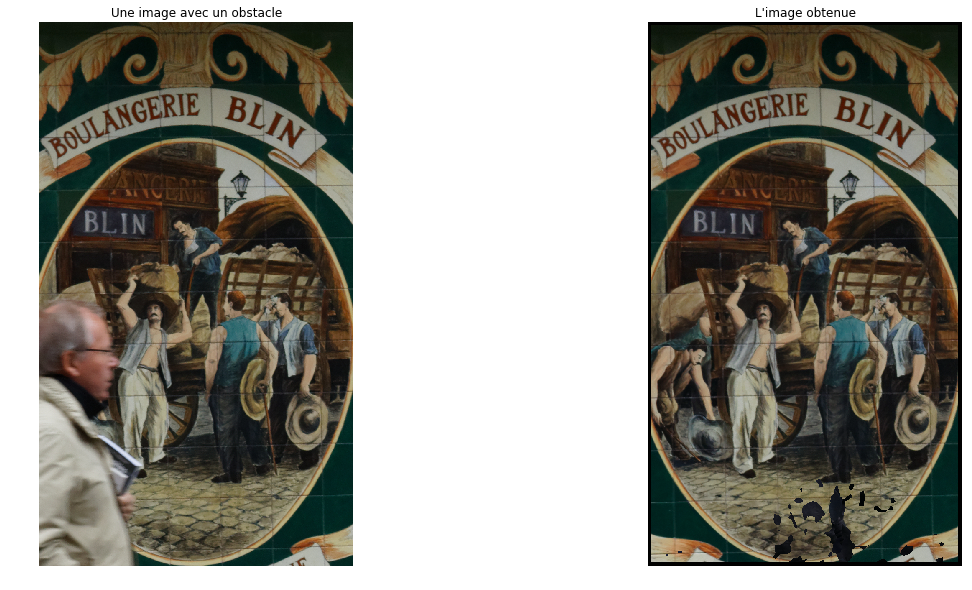

In [76]:
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.title("Une image avec un obstacle")
plt.imshow(boulangerie[0])
plt.axis('off')
plt.subplot(122)
plt.title("L'image obtenue")
plt.imshow(boulangerie_patch_8.astype(np.uint8))
plt.axis('off')

plt.show()